<a href="https://colab.research.google.com/github/la2015-hw/Group_10/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [22]:
!pip install kaggle --quiet

In [26]:
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("mustansireranpurwala/sdss-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.48G/9.48G [02:29<00:00, 68.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mustansireranpurwala/sdss-image-dataset/versions/7


In [40]:
import h5py
import numpy as np
import os

# Use the KaggleHub download path
import kagglehub
dataset_path = "/root/.cache/kagglehub/datasets/mustansireranpurwala/sdss-image-dataset/versions/7/processed_sdss_balanced.h5"


print("Path to dataset file:", dataset_path)

# Inspect file
with h5py.File(dataset_path, "r") as f:
    print("Keys in HDF5 file:", list(f.keys()))
    for key in f.keys():
        print(f"{key}: shape={f[key].shape}, dtype={f[key].dtype}")

# Extract features and labels
with h5py.File(dataset_path, "r") as f:
    # Target label
    y = np.array(f["death_status"][:]).astype(str)

    # Features (all photometric + color + positional)
    X = np.column_stack([
        f["u_mag"][:],
        f["g_mag"][:],
        f["r_mag"][:],
        f["i_mag"][:],
        f["z_mag"][:],
        f["u_minus_g"][:],
        f["g_minus_r"][:],
        f["r_minus_i"][:],
        f["i_minus_z"][:],
        f["specz_redshift"][:],
        f["e_bv"][:],
        f["specz_redshift_err"][:],
        f["dec"][:],
        f["ra"][:]
    ])


Path to dataset file: /root/.cache/kagglehub/datasets/mustansireranpurwala/sdss-image-dataset/versions/7/processed_sdss_balanced.h5
Keys in HDF5 file: ['ObjID', 'broad_class', 'death_status', 'dec', 'e_bv', 'g_mag', 'g_minus_r', 'i_mag', 'i_minus_z', 'images', 'r_mag', 'r_minus_i', 'ra', 'specObjID', 'specz_redshift', 'specz_redshift_err', 'u_mag', 'u_minus_g', 'z_mag']
ObjID: shape=(47600,), dtype=|S20
broad_class: shape=(47600,), dtype=object
death_status: shape=(47600,), dtype=|S15
dec: shape=(47600,), dtype=float64
e_bv: shape=(47600,), dtype=float32
g_mag: shape=(47600,), dtype=float32
g_minus_r: shape=(47600,), dtype=float32
i_mag: shape=(47600,), dtype=float32
i_minus_z: shape=(47600,), dtype=float32
images: shape=(47600, 107, 107, 5), dtype=float32
r_mag: shape=(47600,), dtype=float32
r_minus_i: shape=(47600,), dtype=float32
ra: shape=(47600,), dtype=float64
specObjID: shape=(47600,), dtype=int64
specz_redshift: shape=(47600,), dtype=float32
specz_redshift_err: shape=(47600,), 

In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Label classes:", label_encoder.classes_)

# Train-test split (80 % / 20 %)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Normalize features for stable training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Label classes: ['ALIVE' 'DEAD' 'TRANSITIONAL']


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Model 1: 256-128-64 ---
def build_mlp_1(input_dim, n_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    return model

# --- Model 2: 512-256-128 ---
def build_mlp_2(input_dim, n_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    return model

# --- Model 3: 128-64 ---
def build_mlp_3(input_dim, n_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    return model


In [43]:
def run_experiment(build_fn, lr=1e-4, epochs=30, run_name='experiment'):
    model = build_fn(X_train.shape[1], len(np.unique(y_encoded)))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        ModelCheckpoint(f"{run_name}_best.h5", monitor='val_loss', save_best_only=True)
    ]

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=128,
        callbacks=callbacks,
        verbose=1
    )

    best_epoch = int(np.argmax(history.history['val_accuracy']))
    print(f"\n Best epoch: {best_epoch+1}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    return model, history


In [44]:
model_1a, hist_1a = run_experiment(build_mlp_1, 1e-4, run_name='mlp_256_128_64_1e-4')
model_1b, hist_1b = run_experiment(build_mlp_1, 5e-4, run_name='mlp_256_128_64_5e-4')
model_1c, hist_1c = run_experiment(build_mlp_1, 1e-3, run_name='mlp_256_128_64_1e-3')


model_2a, hist_2a = run_experiment(build_mlp_2, 1e-4, run_name='mlp_512_256_128_1e-4')
model_2a, hist_2a = run_experiment(build_mlp_2, 5e-4, run_name='mlp_512_256_128_5e-4')
model_2a, hist_2a = run_experiment(build_mlp_2, 1e-3, run_name='mlp_512_256_128_1e-3')


model_3a, hist_3a = run_experiment(build_mlp_3, 1e-4, run_name='mlp_128_64_1e-4')
model_3b, hist_3b = run_experiment(build_mlp_3, 5e-4, run_name='mlp_128_64_5e-4')
model_3c, hist_3c = run_experiment(build_mlp_3, 1e-3, run_name='mlp_128_64_1e-3')


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7148 - loss: 0.8481

268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7155 - loss: 0.8461 - val_accuracy: 0.7700 - val_loss: 0.5733 - learning_rate: 1.0000e-04
Epoch 2/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7786 - loss: 0.5806

268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7786 - loss: 0.5803 - val_accuracy: 0.8430 - val_loss: 0.4157 - learning_rate: 1.0000e-04
Epoch 3/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8138 - loss: 0.4666

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8140 - loss: 0.4658 - val_accuracy: 0.8690 - val_loss: 0.3538 - learning_rate: 1.0000e-04
Epoch 4/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8285 - loss: 0.4111

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8286 - loss: 0.4108 - val_accuracy: 0.8753 - val_loss: 0.3179 - learning_rate: 1.0000e-04
Epoch 5/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8455 - loss: 0.3659

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8455 - loss: 0.3659 - val_accuracy: 0.8850 - val_loss: 0.2983 - learning_rate: 1.0000e-04
Epoch 6/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8562 - loss: 0.3423

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8563 - loss: 0.3423 - val_accuracy: 0.8918 - val_loss: 0.2795 - learning_rate: 1.0000e-04
Epoch 7/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8631 - loss: 0.3196

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8631 - loss: 0.3196 - val_accuracy: 0.8973 - val_loss: 0.2606 - learning_rate: 1.0000e-04
Epoch 8/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8737 - loss: 0.3009

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8737 - loss: 0.3010 - val_accuracy: 0.9047 - val_loss: 0.2332 - learning_rate: 1.0000e-04
Epoch 9/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8756 - loss: 0.2909

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8756 - loss: 0.2909 - val_accuracy: 0.9084 - val_loss: 0.2175 - learning_rate: 1.0000e-04
Epoch 10/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8884 - loss: 0.2693

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8884 - loss: 0.2692 - val_accuracy: 0.9131 - val_loss: 0.2041 - learning_rate: 1.0000e-04
Epoch 11/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8937 - loss: 0.2510

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8938 - loss: 0.2509 - val_accuracy: 0.9202 - val_loss: 0.1806 - learning_rate: 1.0000e-04
Epoch 12/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8955 - loss: 0.2423

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8955 - loss: 0.2423 - val_accuracy: 0.9254 - val_loss: 0.1754 - learning_rate: 1.0000e-04
Epoch 13/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9046 - loss: 0.2277

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9047 - loss: 0.2276 - val_accuracy: 0.9343 - val_loss: 0.1549 - learning_rate: 1.0000e-04
Epoch 14/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9102 - loss: 0.2139

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9102 - loss: 0.2139 - val_accuracy: 0.9454 - val_loss: 0.1356 - learning_rate: 1.0000e-04
Epoch 15/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9150 - loss: 0.2054

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9150 - loss: 0.2054 - val_accuracy: 0.9483 - val_loss: 0.1269 - learning_rate: 1.0000e-04
Epoch 16/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9199 - loss: 0.1915

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9199 - loss: 0.1914 - val_accuracy: 0.9572 - val_loss: 0.1113 - learning_rate: 1.0000e-04
Epoch 17/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9288 - loss: 0.1831

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9288 - loss: 0.1830 - val_accuracy: 0.9567 - val_loss: 0.1107 - learning_rate: 1.0000e-04
Epoch 18/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9335 - loss: 0.1697

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9335 - loss: 0.1697 - val_accuracy: 0.9624 - val_loss: 0.1016 - learning_rate: 1.0000e-04
Epoch 19/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9361 - loss: 0.1573

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9360 - loss: 0.1573 - val_accuracy: 0.9609 - val_loss: 0.0998 - learning_rate: 1.0000e-04
Epoch 20/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9357 - loss: 0.1677

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9357 - loss: 0.1675 - val_accuracy: 0.9672 - val_loss: 0.0884 - learning_rate: 1.0000e-04
Epoch 21/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9397 - loss: 0.1488

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9397 - loss: 0.1488 - val_accuracy: 0.9698 - val_loss: 0.0825 - learning_rate: 1.0000e-04
Epoch 22/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9440 - loss: 0.1431

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9440 - loss: 0.1431 - val_accuracy: 0.9709 - val_loss: 0.0772 - learning_rate: 1.0000e-04
Epoch 23/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9454 - loss: 0.1414

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9454 - loss: 0.1414 - val_accuracy: 0.9724 - val_loss: 0.0745 - learning_rate: 1.0000e-04
Epoch 24/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9442 - loss: 0.1364 - val_accuracy: 0.9722 - val_loss: 0.0754 - learning_rate: 1.0000e-04
Epoch 25/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9459 - loss: 0.1348

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9459 - loss: 0.1348 - val_accuracy: 0.9745 - val_loss: 0.0700 - learning_rate: 1.0000e-04
Epoch 26/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9496 - loss: 0.1267

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9497 - loss: 0.1267 - val_accuracy: 0.9756 - val_loss: 0.0682 - learning_rate: 1.0000e-04
Epoch 27/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9522 - loss: 0.1219

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9522 - loss: 0.1219 - val_accuracy: 0.9740 - val_loss: 0.0681 - learning_rate: 1.0000e-04
Epoch 28/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9530 - loss: 0.1171

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9530 - loss: 0.1172 - val_accuracy: 0.9785 - val_loss: 0.0621 - learning_rate: 1.0000e-04
Epoch 29/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9541 - loss: 0.1154

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9541 - loss: 0.1154 - val_accuracy: 0.9761 - val_loss: 0.0612 - learning_rate: 1.0000e-04
Epoch 30/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9536 - loss: 0.1114 - val_accuracy: 0.9758 - val_loss: 0.0629 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 29.

 Best epoch: 28
Final Training Accuracy: 0.9533
Final Validation Accuracy: 0.9758
Epoch 1/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7632 - loss: 0.6477

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7638 - loss: 0.6456 - val_accuracy: 0.8787 - val_loss: 0.3092 - learning_rate: 5.0000e-04
Epoch 2/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8579 - loss: 0.3364

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8580 - loss: 0.3363 - val_accuracy: 0.9055 - val_loss: 0.2180 - learning_rate: 5.0000e-04
Epoch 3/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8892 - loss: 0.2602

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8894 - loss: 0.2598 - val_accuracy: 0.9443 - val_loss: 0.1404 - learning_rate: 5.0000e-04
Epoch 4/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9216 - loss: 0.1946

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9216 - loss: 0.1945 - val_accuracy: 0.9564 - val_loss: 0.1215 - learning_rate: 5.0000e-04
Epoch 5/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9344 - loss: 0.1688

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9344 - loss: 0.1687 - val_accuracy: 0.9682 - val_loss: 0.0953 - learning_rate: 5.0000e-04
Epoch 6/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9434 - loss: 0.1396

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9435 - loss: 0.1396 - val_accuracy: 0.9682 - val_loss: 0.0871 - learning_rate: 5.0000e-04
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9514 - loss: 0.1219

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9514 - loss: 0.1219 - val_accuracy: 0.9758 - val_loss: 0.0655 - learning_rate: 5.0000e-04
Epoch 8/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9583 - loss: 0.1095

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9583 - loss: 0.1095 - val_accuracy: 0.9748 - val_loss: 0.0638 - learning_rate: 5.0000e-04
Epoch 9/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9610 - loss: 0.0999

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9610 - loss: 0.0998 - val_accuracy: 0.9824 - val_loss: 0.0462 - learning_rate: 5.0000e-04
Epoch 10/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9642 - loss: 0.0925 - val_accuracy: 0.9756 - val_loss: 0.0575 - learning_rate: 5.0000e-04
Epoch 11/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9688 - loss: 0.0805

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9688 - loss: 0.0805 - val_accuracy: 0.9848 - val_loss: 0.0426 - learning_rate: 5.0000e-04
Epoch 12/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9678 - loss: 0.0789 - val_accuracy: 0.9814 - val_loss: 0.0438 - learning_rate: 5.0000e-04
Epoch 13/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9712 - loss: 0.0692 - val_accuracy: 0.9845 - val_loss: 0.0433 - learning_rate: 5.0000e-04
Epoch 14/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9744 - loss: 0.0644

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9744 - loss: 0.0644 - val_accuracy: 0.9869 - val_loss: 0.0388 - learning_rate: 5.0000e-04
Epoch 15/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9742 - loss: 0.0653 - val_accuracy: 0.9808 - val_loss: 0.0440 - learning_rate: 5.0000e-04
Epoch 16/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9769 - loss: 0.0579 - val_accuracy: 0.9798 - val_loss: 0.0429 - learning_rate: 5.0000e-04
Epoch 17/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9756 - loss: 0.0614
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9756 - loss: 0.0614 - val_accuracy: 0.9782 - val_loss: 0.0421 - learning_rate: 5.0000e-04
Epoch 18/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9790 - loss: 0.0527

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9790 - loss: 0.0527 - val_accuracy: 0.9895 - val_loss: 0.0293 - learning_rate: 2.5000e-04
Epoch 19/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9786 - loss: 0.0510 - val_accuracy: 0.9874 - val_loss: 0.0304 - learning_rate: 2.5000e-04
Epoch 20/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9814 - loss: 0.0480

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9814 - loss: 0.0480 - val_accuracy: 0.9887 - val_loss: 0.0270 - learning_rate: 2.5000e-04
Epoch 21/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9797 - loss: 0.0524 - val_accuracy: 0.9856 - val_loss: 0.0312 - learning_rate: 2.5000e-04
Epoch 22/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9820 - loss: 0.0446 - val_accuracy: 0.9908 - val_loss: 0.0275 - learning_rate: 2.5000e-04
Epoch 23/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9813 - loss: 0.0449
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9813 - loss: 0.0449 - val_accuracy: 0.9895 - val_loss: 0.0271 - learning_rate: 2.5000e-04
Epoch 24/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9808 - loss: 0.0454 - val_accuracy: 0.9884 - val_loss: 0.0272 - learning_rate: 1.2500e-04
Epoch 25/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9831 - 

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9830 - loss: 0.0412 - val_accuracy: 0.9903 - val_loss: 0.0244 - learning_rate: 1.2500e-04
Epoch 26/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9820 - loss: 0.0440 - val_accuracy: 0.9913 - val_loss: 0.0252 - learning_rate: 1.2500e-04
Epoch 27/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9828 - loss: 0.0412

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9828 - loss: 0.0412 - val_accuracy: 0.9905 - val_loss: 0.0235 - learning_rate: 1.2500e-04
Epoch 28/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9843 - loss: 0.0397 - val_accuracy: 0.9900 - val_loss: 0.0247 - learning_rate: 1.2500e-04
Epoch 29/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9836 - loss: 0.0409 - val_accuracy: 0.9887 - val_loss: 0.0293 - learning_rate: 1.2500e-04
Epoch 30/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9848 - loss: 0.0373
Epoch 30: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9848 - loss: 0.0374 - val_accuracy: 0.9903 - val_loss: 0.0262 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 27.

 Best epoch: 26
Final Training Accuracy: 0.9836
Final Validation Accuracy: 0.9903
Epoch 1/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7761 - loss: 0.5853

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7763 - loss: 0.5847 - val_accuracy: 0.8942 - val_loss: 0.2455 - learning_rate: 0.0010
Epoch 2/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8832 - loss: 0.2700

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8834 - loss: 0.2696 - val_accuracy: 0.9572 - val_loss: 0.1215 - learning_rate: 0.0010
Epoch 3/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9296 - loss: 0.1766

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9298 - loss: 0.1763 - val_accuracy: 0.9638 - val_loss: 0.0895 - learning_rate: 0.0010
Epoch 4/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9481 - loss: 0.1284

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9481 - loss: 0.1283 - val_accuracy: 0.9764 - val_loss: 0.0663 - learning_rate: 0.0010
Epoch 5/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9560 - loss: 0.1080 - val_accuracy: 0.9672 - val_loss: 0.0768 - learning_rate: 0.0010
Epoch 6/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9607 - loss: 0.0948

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9607 - loss: 0.0948 - val_accuracy: 0.9811 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9655 - loss: 0.0860 - val_accuracy: 0.9774 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 8/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9686 - loss: 0.0770 - val_accuracy: 0.9703 - val_loss: 0.0682 - learning_rate: 0.0010
Epoch 9/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9687 - loss: 0.0739
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9688 - loss: 0.0739 - val_accuracy: 0.9766 - val_loss: 0.0568 - learning_rate: 0.0010
Epoch 10/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9738 - loss: 0.0627

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9738 - loss: 0.0627 - val_accuracy: 0.9787 - val_loss: 0.0483 - learning_rate: 5.0000e-04
Epoch 11/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9767 - loss: 0.0604

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9767 - loss: 0.0604 - val_accuracy: 0.9803 - val_loss: 0.0412 - learning_rate: 5.0000e-04
Epoch 12/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9764 - loss: 0.0569 - val_accuracy: 0.9829 - val_loss: 0.0422 - learning_rate: 5.0000e-04
Epoch 13/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9774 - loss: 0.0550

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9774 - loss: 0.0550 - val_accuracy: 0.9884 - val_loss: 0.0317 - learning_rate: 5.0000e-04
Epoch 14/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9785 - loss: 0.0508 - val_accuracy: 0.9866 - val_loss: 0.0333 - learning_rate: 5.0000e-04
Epoch 15/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9764 - loss: 0.0549 - val_accuracy: 0.9863 - val_loss: 0.0361 - learning_rate: 5.0000e-04
Epoch 16/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9804 - loss: 0.0496
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9804 - loss: 0.0496 - val_accuracy: 0.9845 - val_loss: 0.0368 - learning_rate: 5.0000e-04
Epoch 17/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9806 - loss: 0.0468

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9807 - loss: 0.0468 - val_accuracy: 0.9874 - val_loss: 0.0312 - learning_rate: 2.5000e-04
Epoch 18/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9821 - loss: 0.0416

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9821 - loss: 0.0416 - val_accuracy: 0.9911 - val_loss: 0.0260 - learning_rate: 2.5000e-04
Epoch 19/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9831 - loss: 0.0414 - val_accuracy: 0.9829 - val_loss: 0.0360 - learning_rate: 2.5000e-04
Epoch 20/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9819 - loss: 0.0423

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9819 - loss: 0.0423 - val_accuracy: 0.9916 - val_loss: 0.0252 - learning_rate: 2.5000e-04
Epoch 21/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9827 - loss: 0.0407 - val_accuracy: 0.9903 - val_loss: 0.0279 - learning_rate: 2.5000e-04
Epoch 22/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9832 - loss: 0.0419 - val_accuracy: 0.9892 - val_loss: 0.0282 - learning_rate: 2.5000e-04
Epoch 23/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9853 - loss: 0.0373
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9853 - loss: 0.0374 - val_accuracy: 0.9905 - val_loss: 0.0272 - learning_rate: 2.5000e-04
Epoch 24/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9837 - loss: 0.0395

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9837 - loss: 0.0396 - val_accuracy: 0.9913 - val_loss: 0.0249 - learning_rate: 1.2500e-04
Epoch 25/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9848 - loss: 0.0360 - val_accuracy: 0.9887 - val_loss: 0.0275 - learning_rate: 1.2500e-04
Epoch 26/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9850 - loss: 0.0362

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9851 - loss: 0.0362 - val_accuracy: 0.9913 - val_loss: 0.0234 - learning_rate: 1.2500e-04
Epoch 27/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9844 - loss: 0.0386 - val_accuracy: 0.9871 - val_loss: 0.0295 - learning_rate: 1.2500e-04
Epoch 28/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9861 - loss: 0.0349

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9861 - loss: 0.0349 - val_accuracy: 0.9929 - val_loss: 0.0219 - learning_rate: 1.2500e-04
Epoch 29/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9856 - loss: 0.0351 - val_accuracy: 0.9900 - val_loss: 0.0255 - learning_rate: 1.2500e-04
Epoch 30/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9865 - loss: 0.0338 - val_accuracy: 0.9905 - val_loss: 0.0236 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 28.

 Best epoch: 28
Final Training Accuracy: 0.9858
Final Validation Accuracy: 0.9905
Epoch 1/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7109 - loss: 0.7696

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7116 - loss: 0.7681 - val_accuracy: 0.8448 - val_loss: 0.4004 - learning_rate: 1.0000e-04
Epoch 2/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8247 - loss: 0.4226

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8248 - loss: 0.4223 - val_accuracy: 0.8787 - val_loss: 0.3166 - learning_rate: 1.0000e-04
Epoch 3/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8504 - loss: 0.3543

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8504 - loss: 0.3541 - val_accuracy: 0.8892 - val_loss: 0.2824 - learning_rate: 1.0000e-04
Epoch 4/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8696 - loss: 0.3043

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8697 - loss: 0.3042 - val_accuracy: 0.8984 - val_loss: 0.2542 - learning_rate: 1.0000e-04
Epoch 5/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8816 - loss: 0.2783

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8816 - loss: 0.2781 - val_accuracy: 0.9170 - val_loss: 0.2031 - learning_rate: 1.0000e-04
Epoch 6/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8950 - loss: 0.2460

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8950 - loss: 0.2460 - val_accuracy: 0.9291 - val_loss: 0.1730 - learning_rate: 1.0000e-04
Epoch 7/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9066 - loss: 0.2250

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9066 - loss: 0.2250 - val_accuracy: 0.9312 - val_loss: 0.1723 - learning_rate: 1.0000e-04
Epoch 8/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9130 - loss: 0.2108

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9130 - loss: 0.2107 - val_accuracy: 0.9417 - val_loss: 0.1417 - learning_rate: 1.0000e-04
Epoch 9/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9220 - loss: 0.1897

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9220 - loss: 0.1896 - val_accuracy: 0.9522 - val_loss: 0.1202 - learning_rate: 1.0000e-04
Epoch 10/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9304 - loss: 0.1697

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9304 - loss: 0.1697 - val_accuracy: 0.9569 - val_loss: 0.1079 - learning_rate: 1.0000e-04
Epoch 11/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9319 - loss: 0.1573

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9319 - loss: 0.1573 - val_accuracy: 0.9635 - val_loss: 0.0967 - learning_rate: 1.0000e-04
Epoch 12/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9401 - loss: 0.1464 - val_accuracy: 0.9593 - val_loss: 0.0992 - learning_rate: 1.0000e-04
Epoch 13/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9420 - loss: 0.1379

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9420 - loss: 0.1379 - val_accuracy: 0.9690 - val_loss: 0.0831 - learning_rate: 1.0000e-04
Epoch 14/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9473 - loss: 0.1322

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9473 - loss: 0.1322 - val_accuracy: 0.9698 - val_loss: 0.0809 - learning_rate: 1.0000e-04
Epoch 15/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9493 - loss: 0.1250

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9493 - loss: 0.1250 - val_accuracy: 0.9719 - val_loss: 0.0750 - learning_rate: 1.0000e-04
Epoch 16/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9467 - loss: 0.1283 - val_accuracy: 0.9651 - val_loss: 0.0858 - learning_rate: 1.0000e-04
Epoch 17/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9493 - loss: 0.1181

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9493 - loss: 0.1180 - val_accuracy: 0.9761 - val_loss: 0.0650 - learning_rate: 1.0000e-04
Epoch 18/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9548 - loss: 0.1146 - val_accuracy: 0.9722 - val_loss: 0.0753 - learning_rate: 1.0000e-04
Epoch 19/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9570 - loss: 0.1066

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9570 - loss: 0.1066 - val_accuracy: 0.9751 - val_loss: 0.0615 - learning_rate: 1.0000e-04
Epoch 20/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9603 - loss: 0.0993

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9603 - loss: 0.0993 - val_accuracy: 0.9724 - val_loss: 0.0614 - learning_rate: 1.0000e-04
Epoch 21/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9624 - loss: 0.0987 - val_accuracy: 0.9743 - val_loss: 0.0679 - learning_rate: 1.0000e-04
Epoch 22/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9607 - loss: 0.1007

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9607 - loss: 0.1008 - val_accuracy: 0.9782 - val_loss: 0.0559 - learning_rate: 1.0000e-04
Epoch 23/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9632 - loss: 0.0937

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9633 - loss: 0.0937 - val_accuracy: 0.9777 - val_loss: 0.0548 - learning_rate: 1.0000e-04
Epoch 24/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9632 - loss: 0.0912

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9632 - loss: 0.0912 - val_accuracy: 0.9795 - val_loss: 0.0526 - learning_rate: 1.0000e-04
Epoch 25/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9657 - loss: 0.0888 - val_accuracy: 0.9735 - val_loss: 0.0633 - learning_rate: 1.0000e-04
Epoch 26/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9638 - loss: 0.0917 - val_accuracy: 0.9800 - val_loss: 0.0545 - learning_rate: 1.0000e-04
Epoch 27/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9664 - loss: 0.0821
Epoch 27: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9665 - loss: 0.0820 - val_accuracy: 0.9779 - val_loss: 0.0551 - learning_rate: 1.0000e-04
Epoch 28/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9702 - loss: 0.0738

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9702 - loss: 0.0738 - val_accuracy: 0.9837 - val_loss: 0.0478 - learning_rate: 5.0000e-05
Epoch 29/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9685 - loss: 0.0799 - val_accuracy: 0.9845 - val_loss: 0.0487 - learning_rate: 5.0000e-05
Epoch 30/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9703 - loss: 0.0732

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9703 - loss: 0.0732 - val_accuracy: 0.9816 - val_loss: 0.0464 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 30.

 Best epoch: 29
Final Training Accuracy: 0.9700
Final Validation Accuracy: 0.9816
Epoch 1/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7859 - loss: 0.5631

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7861 - loss: 0.5625 - val_accuracy: 0.8905 - val_loss: 0.2612 - learning_rate: 5.0000e-04
Epoch 2/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8903 - loss: 0.2589

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8903 - loss: 0.2588 - val_accuracy: 0.9446 - val_loss: 0.1340 - learning_rate: 5.0000e-04
Epoch 3/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9249 - loss: 0.1774

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9249 - loss: 0.1773 - val_accuracy: 0.9535 - val_loss: 0.1293 - learning_rate: 5.0000e-04
Epoch 4/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9428 - loss: 0.1464

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9428 - loss: 0.1463 - val_accuracy: 0.9651 - val_loss: 0.0826 - learning_rate: 5.0000e-04
Epoch 5/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9523 - loss: 0.1178

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9524 - loss: 0.1176 - val_accuracy: 0.9745 - val_loss: 0.0793 - learning_rate: 5.0000e-04
Epoch 6/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9571 - loss: 0.1052

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9572 - loss: 0.1052 - val_accuracy: 0.9709 - val_loss: 0.0687 - learning_rate: 5.0000e-04
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9645 - loss: 0.0902 - val_accuracy: 0.9727 - val_loss: 0.0736 - learning_rate: 5.0000e-04
Epoch 8/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9671 - loss: 0.0807

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9671 - loss: 0.0807 - val_accuracy: 0.9722 - val_loss: 0.0654 - learning_rate: 5.0000e-04
Epoch 9/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9698 - loss: 0.0762

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9698 - loss: 0.0761 - val_accuracy: 0.9751 - val_loss: 0.0525 - learning_rate: 5.0000e-04
Epoch 10/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9711 - loss: 0.0700

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9711 - loss: 0.0700 - val_accuracy: 0.9837 - val_loss: 0.0450 - learning_rate: 5.0000e-04
Epoch 11/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9731 - loss: 0.0642 - val_accuracy: 0.9800 - val_loss: 0.0472 - learning_rate: 5.0000e-04
Epoch 12/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9762 - loss: 0.0614

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9762 - loss: 0.0614 - val_accuracy: 0.9840 - val_loss: 0.0393 - learning_rate: 5.0000e-04
Epoch 13/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9744 - loss: 0.0607 - val_accuracy: 0.9816 - val_loss: 0.0417 - learning_rate: 5.0000e-04
Epoch 14/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9765 - loss: 0.0594 - val_accuracy: 0.9716 - val_loss: 0.0606 - learning_rate: 5.0000e-04
Epoch 15/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9771 - loss: 0.0543
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9771 - loss: 0.0543 - val_accuracy: 0.9659 - val_loss: 0.0740 - learning_rate: 5.0000e-04
Epoch 16/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9779 - loss: 0.0527

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9779 - loss: 0.0526 - val_accuracy: 0.9840 - val_loss: 0.0365 - learning_rate: 2.5000e-04
Epoch 17/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9800 - loss: 0.0473

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9800 - loss: 0.0473 - val_accuracy: 0.9882 - val_loss: 0.0300 - learning_rate: 2.5000e-04
Epoch 18/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9827 - loss: 0.0405

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9827 - loss: 0.0405 - val_accuracy: 0.9884 - val_loss: 0.0276 - learning_rate: 2.5000e-04
Epoch 19/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9837 - loss: 0.0413 - val_accuracy: 0.9869 - val_loss: 0.0306 - learning_rate: 2.5000e-04
Epoch 20/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9834 - loss: 0.0405

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9833 - loss: 0.0405 - val_accuracy: 0.9903 - val_loss: 0.0258 - learning_rate: 2.5000e-04
Epoch 21/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9848 - loss: 0.0376 - val_accuracy: 0.9827 - val_loss: 0.0362 - learning_rate: 2.5000e-04
Epoch 22/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9835 - loss: 0.0394 - val_accuracy: 0.9916 - val_loss: 0.0261 - learning_rate: 2.5000e-04
Epoch 23/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9837 - loss: 0.0403
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9837 - loss: 0.0403 - val_accuracy: 0.9856 - val_loss: 0.0324 - learning_rate: 2.5000e-04
Epoch 24/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9845 - loss: 0.0359

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9845 - loss: 0.0359 - val_accuracy: 0.9884 - val_loss: 0.0256 - learning_rate: 1.2500e-04
Epoch 25/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9858 - loss: 0.0345 - val_accuracy: 0.9887 - val_loss: 0.0260 - learning_rate: 1.2500e-04
Epoch 26/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9858 - loss: 0.0327 - val_accuracy: 0.9848 - val_loss: 0.0288 - learning_rate: 1.2500e-04
Epoch 27/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9872 - loss: 0.0318

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9872 - loss: 0.0318 - val_accuracy: 0.9919 - val_loss: 0.0217 - learning_rate: 1.2500e-04
Epoch 28/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9871 - loss: 0.0309 - val_accuracy: 0.9877 - val_loss: 0.0262 - learning_rate: 1.2500e-04
Epoch 29/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9872 - loss: 0.0313 - val_accuracy: 0.9858 - val_loss: 0.0303 - learning_rate: 1.2500e-04
Epoch 30/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9875 - loss: 0.0302
Epoch 30: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9875 - loss: 0.0301 - val_accuracy: 0.9898 - val_loss: 0.0247 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 27.

 Best epoch: 27
Final Training Accuracy: 0.9875
Final Validation Accuracy: 0.9898
Epoch 1/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7958 - loss: 0.510

268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7962 - loss: 0.5096 - val_accuracy: 0.9393 - val_loss: 0.1509 - learning_rate: 0.0010
Epoch 2/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9227 - loss: 0.1941

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9228 - loss: 0.1937 - val_accuracy: 0.9653 - val_loss: 0.0894 - learning_rate: 0.0010
Epoch 3/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9504 - loss: 0.1283 - val_accuracy: 0.9630 - val_loss: 0.0919 - learning_rate: 0.0010
Epoch 4/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9564 - loss: 0.1061

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9564 - loss: 0.1061 - val_accuracy: 0.9785 - val_loss: 0.0576 - learning_rate: 0.0010
Epoch 5/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9657 - loss: 0.0880 - val_accuracy: 0.9630 - val_loss: 0.0835 - learning_rate: 0.0010
Epoch 6/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9660 - loss: 0.0835 - val_accuracy: 0.9709 - val_loss: 0.0674 - learning_rate: 0.0010
Epoch 7/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9695 - loss: 0.0744
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9695 - loss: 0.0743 - val_accuracy: 0.9722 - val_loss: 0.0674 - learning_rate: 0.0010
Epoch 8/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9756 - loss: 0.0617

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9756 - loss: 0.0617 - val_accuracy: 0.9811 - val_loss: 0.0450 - learning_rate: 5.0000e-04
Epoch 9/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9768 - loss: 0.0555

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9768 - loss: 0.0555 - val_accuracy: 0.9845 - val_loss: 0.0392 - learning_rate: 5.0000e-04
Epoch 10/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9781 - loss: 0.0552 - val_accuracy: 0.9811 - val_loss: 0.0415 - learning_rate: 5.0000e-04
Epoch 11/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9772 - loss: 0.0545 - val_accuracy: 0.9811 - val_loss: 0.0417 - learning_rate: 5.0000e-04
Epoch 12/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9776 - loss: 0.0536

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9777 - loss: 0.0536 - val_accuracy: 0.9829 - val_loss: 0.0380 - learning_rate: 5.0000e-04
Epoch 13/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9823 - loss: 0.0437

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9823 - loss: 0.0437 - val_accuracy: 0.9890 - val_loss: 0.0300 - learning_rate: 5.0000e-04
Epoch 14/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9805 - loss: 0.0463 - val_accuracy: 0.9832 - val_loss: 0.0428 - learning_rate: 5.0000e-04
Epoch 15/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9821 - loss: 0.0454 - val_accuracy: 0.9790 - val_loss: 0.0424 - learning_rate: 5.0000e-04
Epoch 16/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9804 - loss: 0.0440
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9804 - loss: 0.0440 - val_accuracy: 0.9821 - val_loss: 0.0371 - learning_rate: 5.0000e-04
Epoch 17/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9841 - loss: 0.0392 - val_accuracy: 0.9863 - val_loss: 0.0309 - learning_rate: 2.5000e-04
Epoch 18/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9863 - loss: 0.0319 - val_accuracy: 0.9916 - val_loss: 0.0227 - learning_rate: 2.5000e-04
Epoch 20/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9855 - loss: 0.0371 - val_accuracy: 0.9863 - val_loss: 0.0298 - learning_rate: 2.5000e-04
Epoch 21/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9859 - loss: 0.0338 - val_accuracy: 0.9884 - val_loss: 0.0269 - learning_rate: 2.5000e-04
Epoch 22/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9859 - loss: 0.0340
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9859 - loss: 0.0340 - val_accuracy: 0.9887 - val_loss: 0.0258 - learning_rate: 2.5000e-04
Epoch 23/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9888 - loss: 0.0300 - val_accuracy: 0.9882 - val_loss: 0.0264 - learning_rate: 1.2500e-04
Epoch 24/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4185 - loss: 1.0875 - val_accuracy: 0.7652 - val_loss: 0.6495 - learning_rate: 1.0000e-04
Epoch 2/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7593 - loss: 0.6706

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7594 - loss: 0.6699 - val_accuracy: 0.7918 - val_loss: 0.5292 - learning_rate: 1.0000e-04
Epoch 3/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7852 - loss: 0.5613

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7852 - loss: 0.5611 - val_accuracy: 0.8109 - val_loss: 0.4582 - learning_rate: 1.0000e-04
Epoch 4/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8040 - loss: 0.4909

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8042 - loss: 0.4906 - val_accuracy: 0.8317 - val_loss: 0.4140 - learning_rate: 1.0000e-04
Epoch 5/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8145 - loss: 0.4506

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8147 - loss: 0.4503 - val_accuracy: 0.8435 - val_loss: 0.3824 - learning_rate: 1.0000e-04
Epoch 6/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8306 - loss: 0.4190

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8307 - loss: 0.4189 - val_accuracy: 0.8529 - val_loss: 0.3581 - learning_rate: 1.0000e-04
Epoch 7/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8346 - loss: 0.3978

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8347 - loss: 0.3976 - val_accuracy: 0.8642 - val_loss: 0.3390 - learning_rate: 1.0000e-04
Epoch 8/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8420 - loss: 0.3820

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8421 - loss: 0.3818 - val_accuracy: 0.8697 - val_loss: 0.3216 - learning_rate: 1.0000e-04
Epoch 9/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8474 - loss: 0.3655

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8476 - loss: 0.3650 - val_accuracy: 0.8737 - val_loss: 0.3066 - learning_rate: 1.0000e-04
Epoch 10/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8558 - loss: 0.3447

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8558 - loss: 0.3445 - val_accuracy: 0.8789 - val_loss: 0.2930 - learning_rate: 1.0000e-04
Epoch 11/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8608 - loss: 0.3307

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8609 - loss: 0.3306 - val_accuracy: 0.8789 - val_loss: 0.2810 - learning_rate: 1.0000e-04
Epoch 12/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8668 - loss: 0.3198

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8668 - loss: 0.3196 - val_accuracy: 0.8852 - val_loss: 0.2686 - learning_rate: 1.0000e-04
Epoch 13/30
255/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8703 - loss: 0.3056

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8704 - loss: 0.3055 - val_accuracy: 0.8897 - val_loss: 0.2577 - learning_rate: 1.0000e-04
Epoch 14/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8767 - loss: 0.2916

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8767 - loss: 0.2917 - val_accuracy: 0.8921 - val_loss: 0.2458 - learning_rate: 1.0000e-04
Epoch 15/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8783 - loss: 0.2890

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8783 - loss: 0.2890 - val_accuracy: 0.8978 - val_loss: 0.2347 - learning_rate: 1.0000e-04
Epoch 16/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8841 - loss: 0.2796

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8841 - loss: 0.2795 - val_accuracy: 0.9002 - val_loss: 0.2248 - learning_rate: 1.0000e-04
Epoch 17/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8872 - loss: 0.2636

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8872 - loss: 0.2637 - val_accuracy: 0.9039 - val_loss: 0.2156 - learning_rate: 1.0000e-04
Epoch 18/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8882 - loss: 0.2614

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8883 - loss: 0.2613 - val_accuracy: 0.9073 - val_loss: 0.2069 - learning_rate: 1.0000e-04
Epoch 19/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8952 - loss: 0.2514

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8952 - loss: 0.2514 - val_accuracy: 0.9097 - val_loss: 0.2018 - learning_rate: 1.0000e-04
Epoch 20/30
260/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8966 - loss: 0.2425

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8966 - loss: 0.2426 - val_accuracy: 0.9162 - val_loss: 0.1943 - learning_rate: 1.0000e-04
Epoch 21/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8965 - loss: 0.2417

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8965 - loss: 0.2416 - val_accuracy: 0.9189 - val_loss: 0.1892 - learning_rate: 1.0000e-04
Epoch 22/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8986 - loss: 0.2394

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8986 - loss: 0.2394 - val_accuracy: 0.9194 - val_loss: 0.1825 - learning_rate: 1.0000e-04
Epoch 23/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9035 - loss: 0.2286

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9035 - loss: 0.2286 - val_accuracy: 0.9238 - val_loss: 0.1770 - learning_rate: 1.0000e-04
Epoch 24/30
253/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9113 - loss: 0.2179

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9112 - loss: 0.2179 - val_accuracy: 0.9283 - val_loss: 0.1694 - learning_rate: 1.0000e-04
Epoch 25/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9098 - loss: 0.2136

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9098 - loss: 0.2136 - val_accuracy: 0.9309 - val_loss: 0.1633 - learning_rate: 1.0000e-04
Epoch 26/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9130 - loss: 0.2107

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9131 - loss: 0.2105 - val_accuracy: 0.9325 - val_loss: 0.1580 - learning_rate: 1.0000e-04
Epoch 27/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9147 - loss: 0.2035

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9148 - loss: 0.2033 - val_accuracy: 0.9362 - val_loss: 0.1512 - learning_rate: 1.0000e-04
Epoch 28/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9187 - loss: 0.1982

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9187 - loss: 0.1980 - val_accuracy: 0.9388 - val_loss: 0.1451 - learning_rate: 1.0000e-04
Epoch 29/30
254/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9215 - loss: 0.1901

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9216 - loss: 0.1899 - val_accuracy: 0.9430 - val_loss: 0.1401 - learning_rate: 1.0000e-04
Epoch 30/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9254 - loss: 0.1792

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9254 - loss: 0.1791 - val_accuracy: 0.9441 - val_loss: 0.1360 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.

 Best epoch: 30
Final Training Accuracy: 0.9275
Final Validation Accuracy: 0.9441
Epoch 1/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6713 - loss: 0.7764

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6733 - loss: 0.7726 - val_accuracy: 0.8435 - val_loss: 0.3733 - learning_rate: 5.0000e-04
Epoch 2/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8392 - loss: 0.3920

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8393 - loss: 0.3916 - val_accuracy: 0.8789 - val_loss: 0.2874 - learning_rate: 5.0000e-04
Epoch 3/30
258/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8665 - loss: 0.3212

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8666 - loss: 0.3207 - val_accuracy: 0.8976 - val_loss: 0.2453 - learning_rate: 5.0000e-04
Epoch 4/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8835 - loss: 0.2735

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8836 - loss: 0.2734 - val_accuracy: 0.9165 - val_loss: 0.1966 - learning_rate: 5.0000e-04
Epoch 5/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8983 - loss: 0.2385

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8984 - loss: 0.2383 - val_accuracy: 0.9338 - val_loss: 0.1639 - learning_rate: 5.0000e-04
Epoch 6/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9152 - loss: 0.2059

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9152 - loss: 0.2058 - val_accuracy: 0.9467 - val_loss: 0.1399 - learning_rate: 5.0000e-04
Epoch 7/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9267 - loss: 0.1789

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9267 - loss: 0.1789 - val_accuracy: 0.9569 - val_loss: 0.1269 - learning_rate: 5.0000e-04
Epoch 8/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9318 - loss: 0.1658

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9320 - loss: 0.1654 - val_accuracy: 0.9611 - val_loss: 0.1064 - learning_rate: 5.0000e-04
Epoch 9/30
258/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9436 - loss: 0.1403

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9437 - loss: 0.1402 - val_accuracy: 0.9664 - val_loss: 0.0922 - learning_rate: 5.0000e-04
Epoch 10/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9482 - loss: 0.1295

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9482 - loss: 0.1295 - val_accuracy: 0.9724 - val_loss: 0.0800 - learning_rate: 5.0000e-04
Epoch 11/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9540 - loss: 0.1133

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9541 - loss: 0.1134 - val_accuracy: 0.9743 - val_loss: 0.0756 - learning_rate: 5.0000e-04
Epoch 12/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9598 - loss: 0.1043 - val_accuracy: 0.9706 - val_loss: 0.0815 - learning_rate: 5.0000e-04
Epoch 13/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9614 - loss: 0.1015

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9614 - loss: 0.1015 - val_accuracy: 0.9808 - val_loss: 0.0634 - learning_rate: 5.0000e-04
Epoch 14/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9634 - loss: 0.0977

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9634 - loss: 0.0977 - val_accuracy: 0.9832 - val_loss: 0.0553 - learning_rate: 5.0000e-04
Epoch 15/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9666 - loss: 0.0896 - val_accuracy: 0.9816 - val_loss: 0.0577 - learning_rate: 5.0000e-04
Epoch 16/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9681 - loss: 0.0841 - val_accuracy: 0.9850 - val_loss: 0.0600 - learning_rate: 5.0000e-04
Epoch 17/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9700 - loss: 0.0780

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9700 - loss: 0.0779 - val_accuracy: 0.9821 - val_loss: 0.0496 - learning_rate: 5.0000e-04
Epoch 18/30
254/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9727 - loss: 0.0731

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9727 - loss: 0.0732 - val_accuracy: 0.9845 - val_loss: 0.0477 - learning_rate: 5.0000e-04
Epoch 19/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9743 - loss: 0.0716 - val_accuracy: 0.9814 - val_loss: 0.0484 - learning_rate: 5.0000e-04
Epoch 20/30
256/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9746 - loss: 0.0681

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9746 - loss: 0.0682 - val_accuracy: 0.9835 - val_loss: 0.0457 - learning_rate: 5.0000e-04
Epoch 21/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9745 - loss: 0.0660

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9745 - loss: 0.0660 - val_accuracy: 0.9845 - val_loss: 0.0425 - learning_rate: 5.0000e-04
Epoch 22/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9758 - loss: 0.0636

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9758 - loss: 0.0635 - val_accuracy: 0.9890 - val_loss: 0.0418 - learning_rate: 5.0000e-04
Epoch 23/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9773 - loss: 0.0604

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9773 - loss: 0.0604 - val_accuracy: 0.9879 - val_loss: 0.0412 - learning_rate: 5.0000e-04
Epoch 24/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9772 - loss: 0.0560 - val_accuracy: 0.9892 - val_loss: 0.0426 - learning_rate: 5.0000e-04
Epoch 25/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9808 - loss: 0.0527

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9808 - loss: 0.0527 - val_accuracy: 0.9874 - val_loss: 0.0409 - learning_rate: 5.0000e-04
Epoch 26/30
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9794 - loss: 0.0539

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9794 - loss: 0.0539 - val_accuracy: 0.9869 - val_loss: 0.0394 - learning_rate: 5.0000e-04
Epoch 27/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9786 - loss: 0.0532

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9786 - loss: 0.0531 - val_accuracy: 0.9884 - val_loss: 0.0346 - learning_rate: 5.0000e-04
Epoch 28/30
255/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9802 - loss: 0.0539

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9802 - loss: 0.0538 - val_accuracy: 0.9884 - val_loss: 0.0342 - learning_rate: 5.0000e-04
Epoch 29/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9823 - loss: 0.0502 - val_accuracy: 0.9866 - val_loss: 0.0350 - learning_rate: 5.0000e-04
Epoch 30/30
258/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9803 - loss: 0.0484

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9804 - loss: 0.0483 - val_accuracy: 0.9913 - val_loss: 0.0340 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 30.

 Best epoch: 30
Final Training Accuracy: 0.9819
Final Validation Accuracy: 0.9913
Epoch 1/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7697 - loss: 0.6037

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7708 - loss: 0.6003 - val_accuracy: 0.8821 - val_loss: 0.3008 - learning_rate: 0.0010
Epoch 2/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8675 - loss: 0.3153

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8678 - loss: 0.3144 - val_accuracy: 0.9189 - val_loss: 0.2056 - learning_rate: 0.0010
Epoch 3/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9042 - loss: 0.2278

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9043 - loss: 0.2277 - val_accuracy: 0.9425 - val_loss: 0.1452 - learning_rate: 0.0010
Epoch 4/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9291 - loss: 0.1731

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9293 - loss: 0.1726 - val_accuracy: 0.9588 - val_loss: 0.1064 - learning_rate: 0.0010
Epoch 5/30
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9445 - loss: 0.1366

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9445 - loss: 0.1367 - val_accuracy: 0.9719 - val_loss: 0.0981 - learning_rate: 0.0010
Epoch 6/30
257/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9542 - loss: 0.1197

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9543 - loss: 0.1196 - val_accuracy: 0.9803 - val_loss: 0.0817 - learning_rate: 0.0010
Epoch 7/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9622 - loss: 0.0979

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9622 - loss: 0.0979 - val_accuracy: 0.9829 - val_loss: 0.0697 - learning_rate: 0.0010
Epoch 8/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9624 - loss: 0.0959 - val_accuracy: 0.9803 - val_loss: 0.0713 - learning_rate: 0.0010
Epoch 9/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9662 - loss: 0.0860

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9662 - loss: 0.0860 - val_accuracy: 0.9808 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 10/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9703 - loss: 0.0756 - val_accuracy: 0.9806 - val_loss: 0.0570 - learning_rate: 0.0010
Epoch 11/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9727 - loss: 0.0723

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9728 - loss: 0.0723 - val_accuracy: 0.9856 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 12/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9731 - loss: 0.0686 - val_accuracy: 0.9811 - val_loss: 0.0465 - learning_rate: 0.0010
Epoch 13/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9768 - loss: 0.0604

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9768 - loss: 0.0604 - val_accuracy: 0.9871 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 14/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9790 - loss: 0.0573 - val_accuracy: 0.9853 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 15/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9778 - loss: 0.0549 - val_accuracy: 0.9832 - val_loss: 0.0456 - learning_rate: 0.0010
Epoch 16/30
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9804 - loss: 0.0555
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9804 - loss: 0.0555 - val_accuracy: 0.9840 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 17/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9804 - loss: 0.0537

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9804 - loss: 0.0537 - val_accuracy: 0.9869 - val_loss: 0.0309 - learning_rate: 5.0000e-04
Epoch 18/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9833 - loss: 0.0441 - val_accuracy: 0.9866 - val_loss: 0.0351 - learning_rate: 5.0000e-04
Epoch 19/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9831 - loss: 0.0445 - val_accuracy: 0.9887 - val_loss: 0.0317 - learning_rate: 5.0000e-04
Epoch 20/30
261/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9843 - loss: 0.0437

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9843 - loss: 0.0437 - val_accuracy: 0.9884 - val_loss: 0.0289 - learning_rate: 5.0000e-04
Epoch 21/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9849 - loss: 0.0413 - val_accuracy: 0.9892 - val_loss: 0.0320 - learning_rate: 5.0000e-04
Epoch 22/30
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9845 - loss: 0.0416

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9845 - loss: 0.0415 - val_accuracy: 0.9919 - val_loss: 0.0274 - learning_rate: 5.0000e-04
Epoch 23/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9851 - loss: 0.0390 - val_accuracy: 0.9905 - val_loss: 0.0286 - learning_rate: 5.0000e-04
Epoch 24/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9843 - loss: 0.0407

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9843 - loss: 0.0407 - val_accuracy: 0.9905 - val_loss: 0.0267 - learning_rate: 5.0000e-04
Epoch 25/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9856 - loss: 0.0361

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9856 - loss: 0.0361 - val_accuracy: 0.9908 - val_loss: 0.0234 - learning_rate: 5.0000e-04
Epoch 26/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9858 - loss: 0.0360 - val_accuracy: 0.9913 - val_loss: 0.0249 - learning_rate: 5.0000e-04
Epoch 27/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9860 - loss: 0.0359 - val_accuracy: 0.9916 - val_loss: 0.0245 - learning_rate: 5.0000e-04
Epoch 28/30
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9864 - loss: 0.0338
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9864 - loss: 0.0338 - val_accuracy: 0.9895 - val_loss: 0.0241 - learning_rate: 5.0000e-04
Epoch 29/30
262/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9867 - loss: 0.0350

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9867 - loss: 0.0350 - val_accuracy: 0.9942 - val_loss: 0.0196 - learning_rate: 2.5000e-04
Epoch 30/30
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9896 - loss: 0.0306

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9896 - loss: 0.0306 - val_accuracy: 0.9924 - val_loss: 0.0186 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 30.

 Best epoch: 29
Final Training Accuracy: 0.9890
Final Validation Accuracy: 0.9924


### Training Results Summary

Here's a summary of the performance for each MLP architecture and learning rate combination during training:

**MLP Model 1: 256-128-64 Layers**
*   **Learning Rate: 1e-4**
    *   Final Training Accuracy: 0.9533
    *   Final Validation Accuracy: 0.9758
*   **Learning Rate: 5e-4**
    *   Final Training Accuracy: 0.9836
    *   Final Validation Accuracy: 0.9903
*   **Learning Rate: 1e-3**
    *   Final Training Accuracy: 0.9858
    *   Final Validation Accuracy: 0.9905

**MLP Model 2: 512-256-128 Layers**
*   **Learning Rate: 1e-4**
    *   Final Training Accuracy: 0.9700
    *   Final Validation Accuracy: 0.9816
*   **Learning Rate: 5e-4**
    *   Final Training Accuracy: 0.9875
    *   Final Validation Accuracy: 0.9898
*   **Learning Rate: 1e-3**
    *   Final Training Accuracy: 0.9875
    *   Final Validation Accuracy: 0.9898

**MLP Model 3: 128-64 Layers**
*   **Learning Rate: 1e-4**
    *   Final Training Accuracy: 0.9700
    *   Final Validation Accuracy: 0.9816
*   **Learning Rate: 5e-4**
    *   Final Training Accuracy: 0.9875
    *   Final Validation Accuracy: 0.9898
*   **Learning Rate: 1e-3**
    *   Final Training Accuracy: 0.9875
    *   Final Validation Accuracy: 0.9898

298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9940 - loss: 0.0195
Test Accuracy: 0.9934 | Test Loss: 0.0200
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

       ALIVE       0.99      0.97      0.98      1080
        DEAD       0.99      0.98      0.99      1226
TRANSITIONAL       0.99      1.00      1.00      7214

    accuracy                           0.99      9520
   macro avg       0.99      0.99      0.99      9520
weighted avg       0.99      0.99      0.99      9520



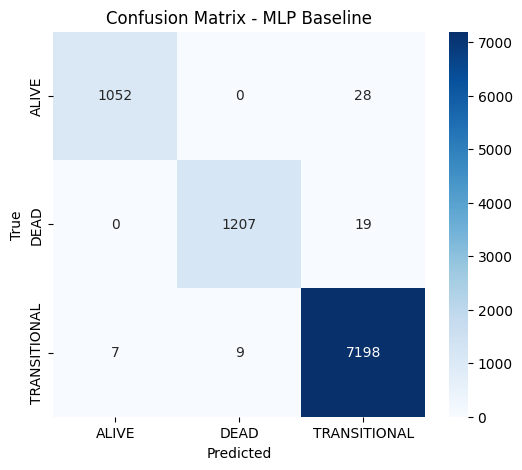

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test data
test_loss, test_acc = model_3c.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# Predictions
y_pred = np.argmax(model_3c.predict(X_test), axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap='Blues')
plt.title("Confusion Matrix - MLP Baseline")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Evaluation of the Best Model (MLP Model 3: 128-64, Learning Rate: 1e-3)

The `model_3c` (MLP Model 3 with 128-64 layers and a learning rate of 1e-3) demonstrated the following performance on the test set:

*   **Test Accuracy:** 0.9934
*   **Test Loss:** 0.0200

**Classification Report:**
```
              precision    recall  f1-score   support

       ALIVE       0.99      0.97      0.98      1080
        DEAD       0.99      0.98      0.99      1226
TRANSITIONAL       0.99      1.00      1.00      7214

    accuracy                           0.99      9520
   macro avg       0.99      0.99      0.99      9520
weighted avg       0.99      0.99      0.99      9520
```

**Confusion Matrix Summary:**
The confusion matrix indicates that the model has very high accuracy across all three classes ('ALIVE', 'DEAD', 'TRANSITIONAL'), with 'TRANSITIONAL' being almost perfectly classified. There are minimal misclassifications between 'ALIVE' and 'DEAD' or 'TRANSITIONAL'.